--- [PART 0] Loading Data ---

--- [PART 1] Descriptive Analytics ---

>> Q1: Top 5 Neighborhoods with Most Barriers:
properties/neighborhood
Industrial District    11481
Ravenna                 5282
Mount Baker             4924
North Beacon Hill       4147
Wallingford             3470
Name: count, dtype: int64

>> Q2: Most Common Barrier Types:
properties/label_type
CurbRamp          27175
NoSidewalk        19133
NoCurbRamp        16947
SurfaceProblem    12681
Obstacle           5693
Occlusion           253
Other                91
Name: count, dtype: int64

>> Q3: Neighborhoods with Highest Average Severity:
properties/neighborhood
Whittier Heights    3.430206
View Ridge          3.419938
Ravenna             3.417517
Interbay            3.352349
Sand Point          3.303371
Name: properties/severity, dtype: float64

--- [PART 2] Feature Engineering ---
Data ready. Training on 63777 samples.

--- [PART 3] Building Pipelines ---

--- [PART 4] Statistical Inference (Statsmodels) ---
OLS 

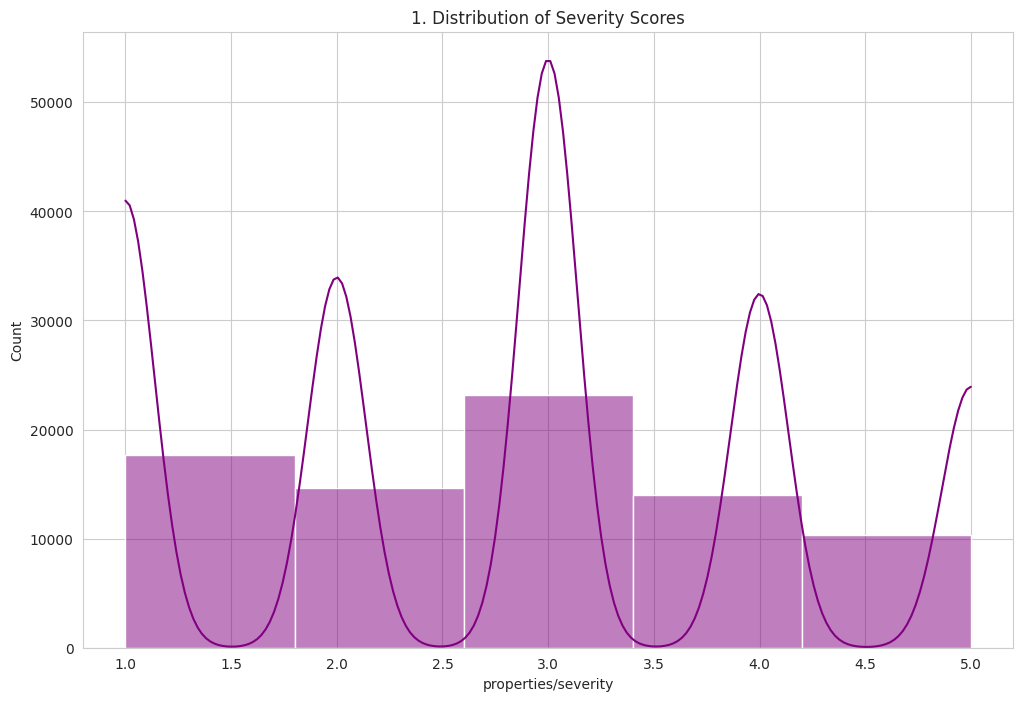

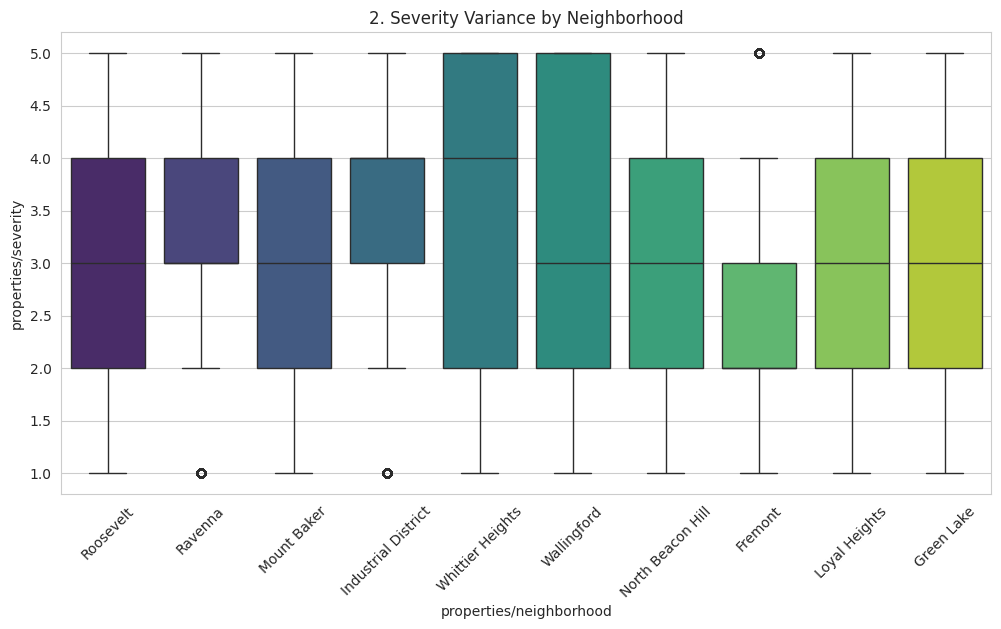

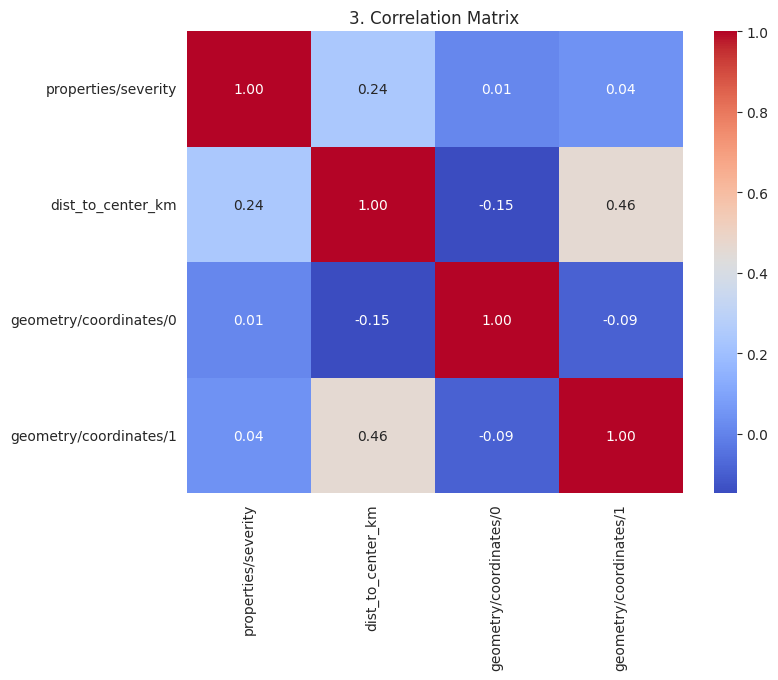

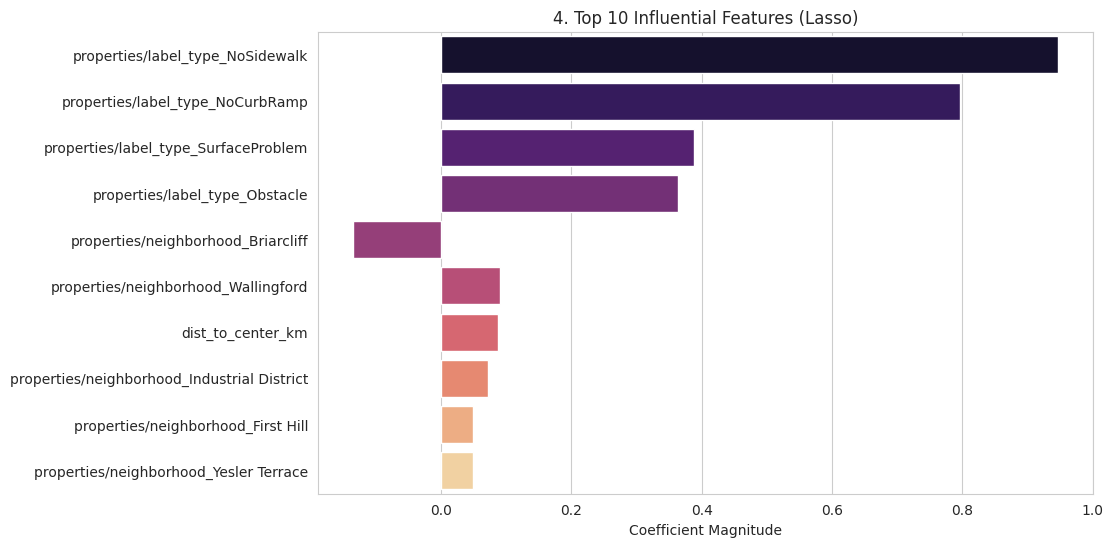

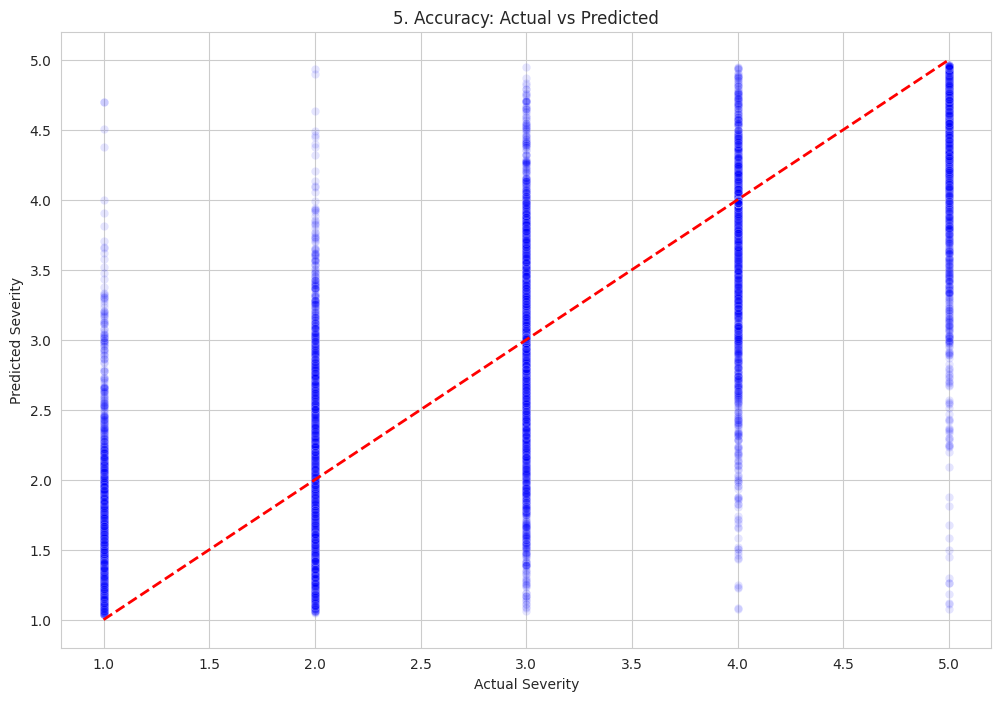

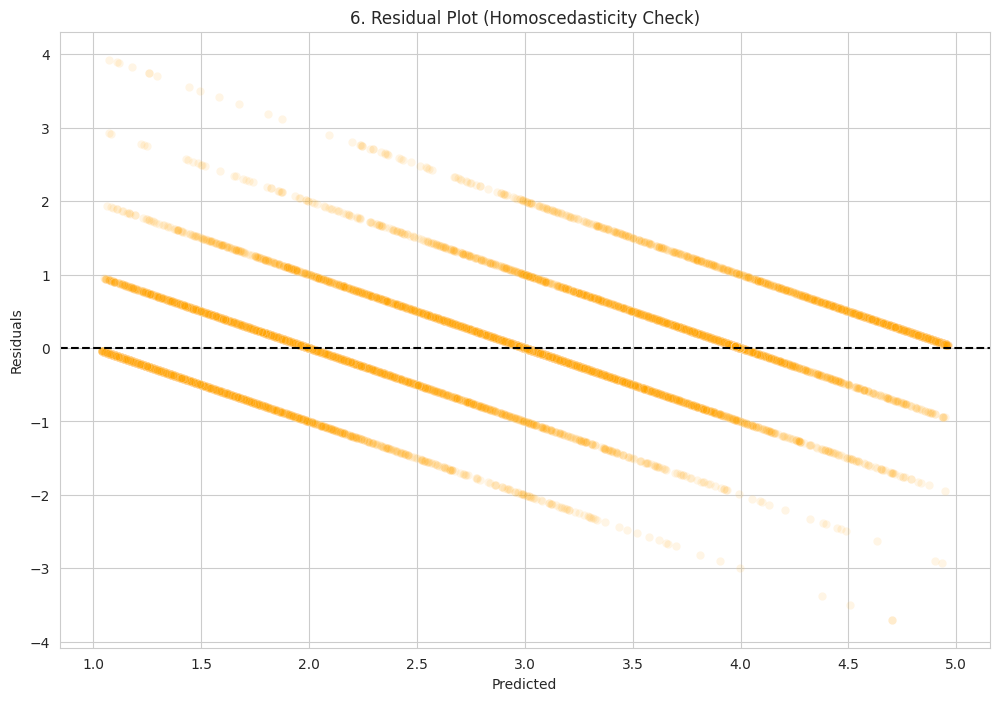

In [ ]:
"""
Topic: Access to Everyday Life (Seattle Accessibility Analysis)
Author: Jayson Xu, Johnson Nguyen, Willy Hung
------------------------------------------------------------------
CONTENTS:
1. Descriptive Analytics (Text answers to business questions)
2. Feature Engineering (Spatial domain knowledge)
3. Statistical Inference (OLS P-values & RSE)
4. Tuning & Selection (Lasso & GridSearch)
5. Stacking Ensemble (RF + KNN + GB + ElasticNet)
6. Comprehensive Evaluation (MAE, MSE, RMSE, RSE, R2)
7. Advanced Visualization Suite (6 Static Plots)
8. Interactive Hotspot Map (DBSCAN Clustering)
------------------------------------------------------------------
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import folium
from folium.plugins import HeatMap, MarkerCluster
import joblib
import warnings
warnings.filterwarnings('ignore')

# Sklearn Core
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set Plot Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ==========================================
# PART 0: Data Loading
# ==========================================
print("--- [PART 0] Loading Data ---")
df = pd.read_csv('Access_to_Everyday_Life_Dataset.csv')

# ==========================================
# PART 1: Descriptive Analytics (Direct Answers)
# ==========================================
print("\n--- [PART 1] Descriptive Analytics ---")
# Q1: Which neighborhoods have the most barriers?
neighborhood_counts = df['properties/neighborhood'].value_counts().head(5)
print(f"\n>> Q1: Top 5 Neighborhoods with Most Barriers:\n{neighborhood_counts}")

# Q2: What types of barriers occur most frequently?
barrier_counts = df['properties/label_type'].value_counts()
print(f"\n>> Q2: Most Common Barrier Types:\n{barrier_counts}")

# Q3: Where are the most severe problems? (Avg Severity)
avg_severity = df.groupby('properties/neighborhood')['properties/severity'].mean().sort_values(ascending=False).head(5)
print(f"\n>> Q3: Neighborhoods with Highest Average Severity:\n{avg_severity}")

# ==========================================
# PART 2: Advanced Feature Engineering
# ==========================================
print("\n--- [PART 2] Feature Engineering ---")
df_clean = df.dropna(subset=['properties/severity']).copy()

# Domain Knowledge: Distance to City Center (Proxy for infrastructure age/density)
seattle_center = (47.6062, -122.3321)
df_clean['lat_dist'] = (df_clean['geometry/coordinates/1'] - seattle_center[0]) * 111
df_clean['long_dist'] = (df_clean['geometry/coordinates/0'] - seattle_center[1]) * 76
df_clean['dist_to_center_km'] = np.sqrt(df_clean['lat_dist']**2 + df_clean['long_dist']**2)

target_col = 'properties/severity'
feature_cols = [
    'geometry/coordinates/0', 'geometry/coordinates/1', 'dist_to_center_km',
    'properties/label_type', 'properties/neighborhood', 'properties/is_temporary'
]
X = df_clean[feature_cols]
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data ready. Training on {X_train.shape[0]} samples.")

# ==========================================
# PART 3: Robust Preprocessing (Scale-After-OHE)
# ==========================================
print("\n--- [PART 3] Building Pipelines ---")
num_cols = ['geometry/coordinates/0', 'geometry/coordinates/1', 'dist_to_center_km']
cat_cols = ['properties/label_type', 'properties/neighborhood', 'properties/is_temporary']

ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop='first', handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ], remainder="drop"
)

prep_pipeline = Pipeline([
    ("col_trans", ct),
    ("scaler", StandardScaler(with_mean=False))
])

# ==========================================
# PART 4: Statistical Inference (OLS)
# ==========================================
print("\n--- [PART 4] Statistical Inference (Statsmodels) ---")
# Transform data for OLS
X_train_dense = prep_pipeline.fit_transform(X_train)
if hasattr(X_train_dense, 'toarray'): X_train_dense = X_train_dense.toarray()

# Add constant for Intercept
X_train_sm = sm.add_constant(X_train_dense)
ols_model = sm.OLS(y_train.values, X_train_sm).fit()

print(f"OLS R-squared (Adj): {ols_model.rsquared_adj:.4f}")
print("P-values and Confidence Intervals calculated internally.")

# ==========================================
# PART 5: Feature Selection & Tuning
# ==========================================
print("\n--- [PART 5] Tuning & Selection ---")

# 1. Lasso for Selection (Interpretability)
lasso = Pipeline([('prep', prep_pipeline), ('model', Lasso(alpha=0.005))])
lasso.fit(X_train, y_train)
print("Lasso Feature Selection complete.")

# 2. GridSearch for Alpha Iteration (ElasticNet)
print("Running GridSearch for ElasticNet...")
enet_pipe = Pipeline([('prep', prep_pipeline), ('model', ElasticNet(random_state=42))])
grid = GridSearchCV(enet_pipe, {'model__alpha': [0.01, 0.1, 1.0]}, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
best_enet = grid.best_estimator_
print(f"Best Alpha Found: {grid.best_params_['model__alpha']}")

# ==========================================
# PART 6: Stacking Ensemble (The Powerhouse)
# ==========================================
print("\n--- [PART 6] Training Stacking Ensemble ---")
# Combining: RF (Non-linear), KNN (Spatial), GB (Boosting), ElasticNet (Linear)
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)),
    ('knn', KNeighborsRegressor(n_neighbors=15, weights="distance")),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ('enet', best_enet.named_steps['model'])
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    cv=3, n_jobs=-1
)

final_pipeline = Pipeline([('prep', prep_pipeline), ('stack', stacking_model)])
final_pipeline.fit(X_train, y_train)
print("Stacking Model Trained.")

# ==========================================
# PART 7: Comprehensive Evaluation
# ==========================================
print("\n--- [PART 7] Final Metrics Report ---")
y_pred = final_pipeline.predict(X_test)

# Standard Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Statistical Metric: RSE (Residual Standard Error)
n = len(y_test)
X_test_transformed = final_pipeline.named_steps['prep'].transform(X_test)
p = X_test_transformed.shape[1] # Number of features
rss = np.sum((y_test - y_pred) ** 2)
test_rse = np.sqrt(rss / (n - p - 2))

print(f">>> FINAL SCORES <<<")
print(f"MAE  (Mean Abs Error):   {mae:.4f}")
print(f"MSE  (Mean Sq Error):    {mse:.4f}")
print(f"RMSE (Root MSE):         {np.sqrt(mse):.4f}")
print(f"RSE  (Residual Std Err): {test_rse:.4f}")
print(f"R^2  (Variance Expl.):   {r2:.4f}")

# ==========================================
# PART 8: Advanced Visualization Suite (6 Plots)
# ==========================================
print("\n--- [PART 8] Generating Visualizations ---")

# 1. Severity Distribution
plt.figure()
sns.histplot(df_clean['properties/severity'], bins=5, kde=True, color='purple')
plt.title('1. Distribution of Severity Scores')
plt.savefig('1_severity_dist.png')

# 2. Neighborhood Boxplot (Top 10)
top_hoods = df_clean['properties/neighborhood'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(x='properties/neighborhood', y='properties/severity',
            data=df_clean[df_clean['properties/neighborhood'].isin(top_hoods)], palette='viridis')
plt.title('2. Severity Variance by Neighborhood')
plt.xticks(rotation=45)
plt.savefig('2_neighborhood_boxplot.png')

# 3. Correlation Matrix (Numeric)
plt.figure(figsize=(8, 6))
corr = df_clean[['properties/severity', 'dist_to_center_km', 'geometry/coordinates/0', 'geometry/coordinates/1']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('3. Correlation Matrix')
plt.savefig('3_correlation.png')

# 4. Feature Importance (Lasso Coefficients)
coefs = lasso.named_steps['model'].coef_
# Logic to extract feature names
ohe = lasso.named_steps['prep'].named_steps['col_trans'].named_transformers_['ohe']
feat_names = np.concatenate([ohe.get_feature_names_out(cat_cols), num_cols])
# Sort Top 10 by magnitude
indices = np.argsort(np.abs(coefs))[::-1][:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=coefs[indices], y=feat_names[indices], palette='magma')
plt.title('4. Top 10 Influential Features (Lasso)')
plt.xlabel('Coefficient Magnitude')
plt.savefig('4_feature_importance.png')

# 5. Actual vs Predicted
plt.figure()
sns.scatterplot(x=y_test, y=y_pred, alpha=0.1, color='blue')
plt.plot([1, 5], [1, 5], 'r--', lw=2)
plt.xlabel('Actual Severity')
plt.ylabel('Predicted Severity')
plt.title('5. Accuracy: Actual vs Predicted')
plt.savefig('5_actual_vs_pred.png')

# 6. Residual Plot
residuals = y_test - y_pred
plt.figure()
sns.scatterplot(x=y_pred, y=residuals, alpha=0.1, color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('6. Residual Plot (Homoscedasticity Check)')
plt.savefig('6_residuals.png')

print("All 6 static plots saved.")

# ==========================================
# PART 9: Interactive Map (DBSCAN Hotspots)
# ==========================================
print("\n--- [PART 9] Generating Interactive Map ---")
severe_data = df_clean[df_clean['properties/severity'] >= 4].copy()
coords = severe_data[['geometry/coordinates/1', 'geometry/coordinates/0']].values

# Clustering
db = DBSCAN(eps=0.002, min_samples=10).fit(coords)
severe_data['cluster'] = db.labels_
n_clusters = len(set(db.labels_)) - 1
print(f"Detected {n_clusters} High-Risk Hotspots.")

# Mapping
m = folium.Map(location=[47.6062, -122.3321], zoom_start=12)
HeatMap(coords, radius=10, blur=15).add_to(m)

for c_id in range(n_clusters):
    cluster_pts = severe_data[severe_data['cluster'] == c_id]
    folium.Marker(
        [cluster_pts['geometry/coordinates/1'].mean(), cluster_pts['geometry/coordinates/0'].mean()],
        popup=f"Hotspot #{c_id} ({len(cluster_pts)} issues)",
        icon=folium.Icon(color='red', icon='warning-sign')
    ).add_to(m)

m.save('Seattle_Accessibility_FINAL.html')
print("Interactive Map saved as 'Seattle_Accessibility_FINAL.html'.")
print("MISSION COMPLETE.")